In [1]:
GLOVE_FILE = 'glove.840B.300d/glove.840B.300d.txt'
PARAGRAM_FILE = 'paragram_300_sl999/paragram_300_sl999.txt'
WIKI_NEWS_FILE = 'wiki-news-300d-1M/wiki-news-300d-1M.vec'
TRAIN_FILE = '/kaggle/input/quora-insincere-questions-classification/train.csv'
TEST_FILE = '/kaggle/input/quora-insincere-questions-classification/test.csv'

In [2]:
!unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {GLOVE_FILE} -d .
!unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {PARAGRAM_FILE} -d .
!unzip -n /kaggle/input/quora-insincere-questions-classification/embeddings.zip {WIKI_NEWS_FILE} -d .

Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
  inflating: ./glove.840B.300d/glove.840B.300d.txt  
Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
  inflating: ./paragram_300_sl999/paragram_300_sl999.txt  
Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
  inflating: ./wiki-news-300d-1M/wiki-news-300d-1M.vec  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc
tqdm().pandas()

0it [00:00, ?it/s]

In [4]:
df = pd.read_csv(TRAIN_FILE)
test_set = pd.read_csv(TEST_FILE)

Num of non_insincere: 1225312
Num of insincere: 80810
Ratio = 1516.29 %


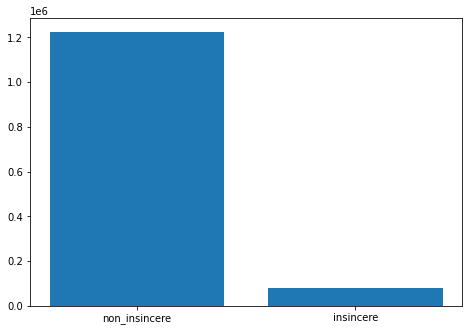

In [5]:
num_insincere = len(df[df['target'] == 1])
num_non_insincere = len(df[df['target'] == 0])
print("Num of non_insincere:", num_non_insincere)
print("Num of insincere:", num_insincere)
print("Ratio = {ratio:.2f} %".format(ratio = num_non_insincere / num_insincere  * 100 ))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['non_insincere', 'insincere'], df.target.value_counts())
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, validate = train_test_split(df, test_size = 0.2)

In [8]:
print("Train: num of non_insincere:", len(train[train.target == 0]))
print("Train: num of insincere:", len(train[train.target == 1]))

print("Validate: num of non_insincere:", len(validate[validate.target == 0]))
print("Validate: num of insincere:", len(validate[validate.target == 1]))

Train: num of non_insincere: 980314
Train: num of insincere: 64583
Validate: num of non_insincere: 244998
Validate: num of insincere: 16227


In [9]:
train_set = train.reset_index(drop=True)
validate_set = validate.reset_index(drop=True)
display(train_set)

,qid,question_text,target
0,4fee00e80bb3d64d66f2,How the first owner can sell his bike in Delhi...,0
1,03d3c9d692c368d7f6bc,Is Justin Trudeau starting to look like a grov...,1
2,36b9894fea27e0454150,How are LiPo batteries made?,0
3,27769979c93112e0293b,Why the period of nihilism not come yet?,0
4,8bf27e97e084307f2440,What do I do if a girl sends me short texts bu...,0
...,...,...,...
1044892,c6362e03011da67a5729,What is the best reference in turbomachinery?,0
1044893,2279ec84f49062e86cdb,Why didn't the Allies copy the Luftwaffe Revi ...,0
1044894,36df1adadd26d5a53905,Which is best secure social network app?,0
1044895,620cc21a89b8a4b7da7a,What would you do if a stranger knocked down y...,0


In [10]:
raw_train_text = train_set.question_text.to_numpy()
train_label = train_set.target.to_numpy()

raw_validate_text = validate_set.question_text.to_numpy()
validate_label = validate_set.target.to_numpy()

raw_test_text = test_set.question_text.to_numpy()

In [11]:
contractions={"I'm":'I am',"I'm'a":'I am about to',"I'm'o":'I am going to',"I've":'I have',"I'll":'I will',"I'll've":'I will have',"I'd":'I would',"I'd've":'I would have','Whatcha':'What are you',"amn't":'am not',"ain't":'are not',"aren't":'are not',"'cause":'because',"can't":'can not',"can't've":'can not have',"could've":'could have',"couldn't":'could not',"couldn't've":'could not have',"daren't":'dare not',"daresn't":'dare not',"dasn't":'dare not',"didn't":'did not','didn’t':'did not',"don't":'do not','don’t':'do not',"doesn't":'does not',"e'er":'ever',"everyone's":'everyone is','finna':'fixing to','gimme':'give me',"gon't":'go not','gonna':'going to','gotta':'got to',"hadn't":'had not',"hadn't've":'had not have',"hasn't":'has not',"haven't":'have not',"he've":'he have',"he's":'he is',"he'll":'he will',"he'll've":'he will have',"he'd":'he would',"he'd've":'he would have',"here's":'here is',"how're":'how are',"how'd":'how did',"how'd'y":'how do you',"how's":'how is',"how'll":'how will',"isn't":'is not',"it's":'it is',"'tis":'it is',"'twas":'it was',"it'll":'it will',"it'll've":'it will have',"it'd":'it would',"it'd've":'it would have','kinda':'kind of',"let's":'let us','luv':'love',"ma'am":'madam',"may've":'may have',"mayn't":'may not',"might've":'might have',"mightn't":'might not',"mightn't've":'might not have',"must've":'must have',"mustn't":'must not',"mustn't've":'must not have',"needn't":'need not',"needn't've":'need not have',"ne'er":'never',"o'":'of',"o'clock":'of the clock',"ol'":'old',"oughtn't":'ought not',"oughtn't've":'ought not have',"o'er":'over',"shan't":'shall not',"sha'n't":'shall not',"shalln't":'shall not',"shan't've":'shall not have',"she's":'she is',"she'll":'she will',"she'd":'she would',"she'd've":'she would have',"should've":'should have',"shouldn't":'should not',"shouldn't've":'should not have',"so've":'so have',"so's":'so is',"somebody's":'somebody is',"someone's":'someone is',"something's":'something is','sux':'sucks',"that're":'that are',"that's":'that is',"that'll":'that will',"that'd":'that would',"that'd've":'that would have','em':'them',"there're":'there are',"there's":'there is',"there'll":'there will',"there'd":'there would',"there'd've":'there would have',"these're":'these are',"they're":'they are',"they've":'they have',"they'll":'they will',"they'll've":'they will have',"they'd":'they would',"they'd've":'they would have',"this's":'this is',"those're":'those are',"to've":'to have','wanna':'want to',"wasn't":'was not',"we're":'we are',"we've":'we have',"we'll":'we will',"we'll've":'we will have',"we'd":'we would',"we'd've":'we would have',"weren't":'were not',"what're":'what are',"what'd":'what did',"what've":'what have',"what's":'what is',"what'll":'what will',"what'll've":'what will have',"when've":'when have',"when's":'when is',"where're":'where are',"where'd":'where did',"where've":'where have',"where's":'where is',"which's":'which is',"who're":'who are',"who've":'who have',"who's":'who is',"who'll":'who will',"who'll've":'who will have',"who'd":'who would',"who'd've":'who would have',"why're":'why are',"why'd":'why did',"why've":'why have',"why's":'why is',"will've":'will have',"won't":'will not',"won't've":'will not have',"would've":'would have',"wouldn't":'would not',"wouldn't've":'would not have',"y'all":'you all',"y'all're":'you all are',"y'all've":'you all have',"y'all'd":'you all would',"y'all'd've":'you all would have',"you're":'you are',"you've":'you have',"you'll've":'you shall have',"you'll":'you will',"you'd":'you would',"you'd've":'you would have','jan.':'january','feb.':'february','mar.':'march','apr.':'april','jun.':'june','jul.':'july','aug.':'august','sep.':'september','oct.':'october','nov.':'november','dec.':'december','I’m':'I am','I’m’a':'I am about to','I’m’o':'I am going to','I’ve':'I have','I’ll':'I will','I’ll’ve':'I will have','I’d':'I would','I’d’ve':'I would have','amn’t':'am not','ain’t':'are not','aren’t':'are not','’cause':'because','can’t':'can not','can’t’ve':'can not have','could’ve':'could have','couldn’t':'could not','couldn’t’ve':'could not have','daren’t':'dare not','daresn’t':'dare not','dasn’t':'dare not','doesn’t':'does not','e’er':'ever','everyone’s':'everyone is','gon’t':'go not','hadn’t':'had not','hadn’t’ve':'had not have','hasn’t':'has not','haven’t':'have not','he’ve':'he have','he’s':'he is','he’ll':'he will','he’ll’ve':'he will have','he’d':'he would','he’d’ve':'he would have','here’s':'here is','how’re':'how are','how’d':'how did','how’d’y':'how do you','how’s':'how is','how’ll':'how will','isn’t':'is not','it’s':'it is','’tis':'it is','’twas':'it was','it’ll':'it will','it’ll’ve':'it will have','it’d':'it would','it’d’ve':'it would have','let’s':'let us','ma’am':'madam','may’ve':'may have','mayn’t':'may not','might’ve':'might have','mightn’t':'might not','mightn’t’ve':'might not have','must’ve':'must have','mustn’t':'must not','mustn’t’ve':'must not have','needn’t':'need not','needn’t’ve':'need not have','ne’er':'never','o’':'of','o’clock':'of the clock','ol’':'old','oughtn’t':'ought not','oughtn’t’ve':'ought not have','o’er':'over','shan’t':'shall not','sha’n’t':'shall not','shalln’t':'shall not','shan’t’ve':'shall not have','she’s':'she is','she’ll':'she will','she’d':'she would','she’d’ve':'she would have','should’ve':'should have','shouldn’t':'should not','shouldn’t’ve':'should not have','so’ve':'so have','so’s':'so is','somebody’s':'somebody is','someone’s':'someone is','something’s':'something is','that’re':'that are','that’s':'that is','that’ll':'that will','that’d':'that would','that’d’ve':'that would have','there’re':'there are','there’s':'there is','there’ll':'there will','there’d':'there would','there’d’ve':'there would have','these’re':'these are','they’re':'they are','they’ve':'they have','they’ll':'they will','they’ll’ve':'they will have','they’d':'they would','they’d’ve':'they would have','this’s':'this is','those’re':'those are','to’ve':'to have','wasn’t':'was not','we’re':'we are','we’ve':'we have','we’ll':'we will','we’ll’ve':'we will have','we’d':'we would','we’d’ve':'we would have','weren’t':'were not','what’re':'what are','what’d':'what did','what’ve':'what have','what’s':'what is','what’ll':'what will','what’ll’ve':'what will have','when’ve':'when have','when’s':'when is','where’re':'where are','where’d':'where did','where’ve':'where have','where’s':'where is','which’s':'which is','who’re':'who are','who’ve':'who have','who’s':'who is','who’ll':'who will','who’ll’ve':'who will have','who’d':'who would','who’d’ve':'who would have','why’re':'why are','why’d':'why did','why’ve':'why have','why’s':'why is','will’ve':'will have','won’t':'will not','won’t’ve':'will not have','would’ve':'would have','wouldn’t':'would not','wouldn’t’ve':'would not have','y’all':'you all','y’all’re':'you all are','y’all’ve':'you all have','y’all’d':'you all would','y’all’d’ve':'you all would have','you’re':'you are','you’ve':'you have','you’ll’ve':'you shall have','you’ll':'you will','you’d':'you would','you’d’ve':'you would have'}
def contraction_fix(word):
  try:
      a=contractions[word]
  except KeyError:
      a=word
  return a

In [12]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [13]:
stop = set(stopwords.words('english'))
print("stopword:",stop)

stopword: {'didn', 'its', 'o', 'most', 'each', 'd', 'y', "hasn't", "shouldn't", 'here', 'yourself', 'was', 'between', 'nor', "mustn't", 'or', 'which', 'any', 'isn', 'his', 'mightn', 'while', 'can', 'what', "you'll", 'for', 'did', 'hers', 'under', "she's", 'why', 'such', 'off', 'does', 'to', "that'll", 'ain', 'up', 'all', 'over', 'in', 'from', 'won', 'out', 'into', "it's", 'where', "wouldn't", 'himself', 'that', 'yours', 'once', 'than', 'the', 'same', 'has', 'against', 'am', 'how', 'about', 'down', 'we', 'm', 'me', 'they', 'too', 'further', 'couldn', 'him', 'doing', 'an', 'when', 'ma', 'there', "mightn't", 'again', 're', 'by', 'is', 'weren', 'had', 'do', 'some', 'aren', 'hadn', 'during', 'should', 'very', 'mustn', 'own', 'at', 'through', "you're", 'will', "won't", 'haven', "needn't", 'you', 'wasn', 'no', 'few', "couldn't", "shan't", 'needn', 'as', "hadn't", 'now', 'themselves', 'shouldn', 'herself', 'just', 'then', "you'd", "weren't", 'her', "aren't", 'them', 'theirs', "haven't", 'this'

In [49]:
import re
def preprocess_text(doc):
  arr = []
  for text in tqdm(doc):
    text=text.lower()
    text=" ".join([contraction_fix(w) for w in text.split()]) # sửa từ viết tắt
#     text=" ".join([w for w in text.split() if w not in stop]) # bỏ stopword

    text=re.sub(r'[^a-zA-Z]'," ",text)
    text = re.sub(r' {2,}', ' ', text)
    arr.append(text.strip())
  return arr

In [50]:
train_text = preprocess_text(raw_train_text)
validate_text = preprocess_text(raw_validate_text)
test_text = preprocess_text(raw_test_text)

  0%|          | 0/1044897 [00:00<?, ?it/s]

  0%|          | 0/261225 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

In [51]:
visualize_preprocessing = pd.DataFrame()
visualize_preprocessing['question_text'] = raw_train_text
visualize_preprocessing['clean_text'] = train_text
with pd.option_context('display.max_colwidth', 100):
    print("Sincere question")
    display(visualize_preprocessing[train_label == 0].head())
    print("Insincere question")
    display(visualize_preprocessing[train_label == 1].head())

Sincere question


,question_text,clean_text
0,How the first owner can sell his bike in Delhi and get good price too?,how the first owner can sell his bike in delhi and get good price too
2,How are LiPo batteries made?,how are lipo batteries made
3,Why the period of nihilism not come yet?,why the period of nihilism not come yet
4,What do I do if a girl sends me short texts but sent me a Snapchat photo 2 weeks ago?,what do i do if a girl sends me short texts but sent me a snapchat photo weeks ago
5,How can I grow beard after applying turmeric powder mistakenly?,how can i grow beard after applying turmeric powder mistakenly


Insincere question


,question_text,clean_text
1,Is Justin Trudeau starting to look like a grovelling suckhole on the world stage?,is justin trudeau starting to look like a grovelling suckhole on the world stage
27,Is Kapil Sibal a 'certified idiot'?,is kapil sibal a certified idiot
29,Why do most Indians look and act aggressive?,why do most indians look and act aggressive
44,Is anything outside of SOCOM in the US military a welfare program for the country’s unproductive?,is anything outside of socom in the us military a welfare program for the country s unproductive
54,"Why even in supposedly ""progressive"" parts of the USA, like San Francisco Bay Area and Los Angel...",why even in supposedly progressive parts of the usa like san francisco bay area and los angeles ...


In [52]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
def get_lines_count(file_name): return sum(1 for _ in open(file_name, encoding="utf8", errors='ignore'))
def load_vec(file_name): return dict(get_coefs(*o.split(" ")) for o in tqdm(open(file_name, encoding="utf8", errors='ignore'), total=get_lines_count(file_name)) if len(o) > 100)

In [53]:
import keras
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','tagger'])

In [54]:

# tần suẩt xuất hiện
vocab_freq = {}
# index của từ
word2index = {}
# từ gốc
lemma_dict = {}
def sentences2sequences(sentences):
    docs = nlp.pipe(sentences, n_threads = 2)
    word_sequences = []
    for doc in tqdm(docs, total=len(sentences)):
        word_seq = []
        for token in doc:
            if token.is_punct:
                continue
            try:
                vocab_freq[token.text] += 1
            except KeyError:
                vocab_freq[token.text] = 1
            if token.text not in word2index:
                word2index[token.text] = len(vocab_freq)
                lemma_dict[token.text] = token.lemma_
            word_seq.append(word2index[token.text])
        word_sequences.append(word_seq)
    return word_sequences

In [55]:
train_sequences = sentences2sequences(train_text)
validate_sequences = sentences2sequences(validate_text)
test_sequences = sentences2sequences(test_text)

vocab_size = len(word2index)
print('Found %s unique tokens.' % len(word2index))

  0%|          | 0/1044897 [00:00<?, ?it/s]

  0%|          | 0/261225 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

Found 204014 unique tokens.


In [56]:
EMBEDDING_DIM = 300
MAX_SENTENCE_LENGTH = 100

In [57]:
from keras.preprocessing.sequence import pad_sequences

padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_SENTENCE_LENGTH)
padded_validate_sequences = pad_sequences(validate_sequences, maxlen=MAX_SENTENCE_LENGTH)
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_SENTENCE_LENGTH)

In [58]:
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

ps = PorterStemmer()
lc = LancasterStemmer()
sb = SnowballStemmer('english')
def load_embedding(word2vec):
    oov_count = 0
    vocab_count = 0
    embedding_weights = np.zeros((vocab_size+1, EMBEDDING_DIM))
    unknown_vector = np.zeros((EMBEDDING_DIM,), dtype=np.float32) - 1.
    unknown_words = {}

    for key, i in tqdm(word2index.items()):
        word = key
        if word in word2vec:
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue
        
        # PorterStemmer ("python","pythoner","pythoning","pythoned" => "python")
        word = ps.stem(key)        
        if word in word2vec:
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue
        
        # LancasterStemmer
        word = lc.stem(key)        
        if word in word2vec:
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue
            
        # SnowballStemmer (connection, connections, connective, connected, and connecting => connect)
        word = sb.stem(key)        
        if word in word2vec:
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue
            
        # Lemmanization
        word = lemma_dict[key]     
        if word in word2vec: 
            vocab_count += vocab_freq[key]
            embedding_weights[i] = word2vec[word]
            continue

        try:
            unknown_words[key] += 1
        except KeyError:
            unknown_words[key] = 1
            
        embedding_weights[i] = unknown_vector
        oov_count += vocab_freq[key]

    print('Top 10 Null word embeddings: ')
    print(list(unknown_words.items())[:10])
    print('\n')
    print('Null word embeddings: %d' % np.sum(np.sum(embedding_weights, axis=1) == -1 * EMBEDDING_DIM))
    print('Null word embeddings percentage: %.2f%%' % (100 * oov_count / vocab_count))
    
    return embedding_weights

In [59]:
print('loading glove_vec')
glove_vec = load_vec(GLOVE_FILE)
glove_weights = load_embedding(glove_vec)
del glove_vec
gc.collect()

loading glove_vec


  0%|          | 0/2196017 [00:00<?, ?it/s]

  0%|          | 0/204014 [00:00<?, ?it/s]

Top 10 Null word embeddings: 
[('flarsky', 1), ('cpec', 1), ('rlwl', 1), ('chsl', 1), ('gohmert', 1), ('capilalized', 1), ('grenfell', 1), ('ssctube', 1), ('qmaths', 1), ('icpf', 1)]


Null word embeddings: 62014
Null word embeddings percentage: 0.50%


0

In [60]:
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.initializers import Constant

In [61]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [62]:
def create_model(units=64):
    output_bias = Constant(np.log([num_insincere/num_non_insincere]))
    
    x_input = Input(shape=(MAX_SENTENCE_LENGTH))
    glove_embedding = Embedding(len(glove_weights), EMBEDDING_DIM, input_length=MAX_SENTENCE_LENGTH, weights=[glove_weights], trainable=False)(x_input)
    x = SpatialDropout1D(0.2)(glove_embedding)
    
    lstm = Bidirectional(LSTM(units, return_sequences=True))(x)
    gru = Bidirectional(GRU(units, return_sequences=True))(lstm)
    
    x = Concatenate()([lstm, gru])
    x = GlobalAveragePooling1D()(x)
    
    x_output = Dense(1, activation='sigmoid', bias_initializer=output_bias)(x)
    
    model = Model(inputs=x_input, outputs=x_output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
    
    return model

In [35]:
# model = create_model_without_pretrain()

In [63]:
import tensorflow as tf

strategy = None

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Use TPU')
except ValueError:
    if len(tf.config.list_physical_devices('GPU')) > 0:
        strategy = tf.distribute.MirroredStrategy()
        print('Use GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('Use CPU')

Use TPU


In [64]:
# !rm best_classification_model/*

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
n_epochs = 10
batch_size=1024
total = num_non_insincere + num_insincere
weight_for_0 = (1 / num_non_insincere) * (total) / 2.0 
weight_for_1 = (1 / num_insincere) * (total) / 2.0
class_weight = {
    0: 1,
    1: 3,
}
print(class_weight)

callbacks = [
    ModelCheckpoint("best_classification_model/best.hdf5", monitor = "val_f1_m", save_best_only = True, mode = "max", verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,min_lr=0.001 ,patience=1)
]

{0: 1, 1: 3}


In [38]:
# history = model.fit(padded_train_sequence, train_label, batch_size=batch_size, epochs=n_epochs, validation_data=(padded_validate_sequence, validate_label), class_weight=class_weight, callbacks = callbacks)

In [65]:
with strategy.scope():
    model = create_model(units = 64)
    
    history = model.fit(padded_train_sequences, train_label, batch_size=batch_size, epochs=n_epochs, validation_data=(padded_validate_sequences, validate_label), class_weight=class_weight, callbacks = callbacks)

Epoch 1/10
1021/1021 [==============================] - 49s 40ms/step - loss: 0.2816 - f1_m: 0.4852 - val_loss: 0.1475 - val_f1_m: 0.6023

Epoch 00001: val_f1_m improved from -inf to 0.60226, saving model to best_classification_model/best.hdf5
Epoch 2/10
1021/1021 [==============================] - 35s 35ms/step - loss: 0.2070 - f1_m: 0.6227 - val_loss: 0.1227 - val_f1_m: 0.6458

Epoch 00002: val_f1_m improved from 0.60226 to 0.64576, saving model to best_classification_model/best.hdf5
Epoch 3/10
1021/1021 [==============================] - 35s 34ms/step - loss: 0.1930 - f1_m: 0.6461 - val_loss: 0.1313 - val_f1_m: 0.6364

Epoch 00003: val_f1_m did not improve from 0.64576
Epoch 4/10
1021/1021 [==============================] - 35s 34ms/step - loss: 0.1842 - f1_m: 0.6574 - val_loss: 0.1157 - val_f1_m: 0.6585

Epoch 00004: val_f1_m improved from 0.64576 to 0.65855, saving model to best_classification_model/best.hdf5
Epoch 5/10
1021/1021 [==============================] - 35s 34ms/step - 

In [66]:
def plot_graph_train(history):
  training_loss = history['loss']
  test_loss = history['val_loss']
  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)
  # Visualize loss history
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1,figsize=(12,4))

  ax1.plot(epoch_count, training_loss, 'r--')
  ax1.legend(['Training Loss'])

  ax2.plot(epoch_count, test_loss, 'b-')
  ax2.legend(['Test Loss'])
  
  val_f1 = history['val_f1_m']
  ax3.plot(epoch_count, val_f1, 'r-' )
  ax3.legend(['f1'])

  plt.show();

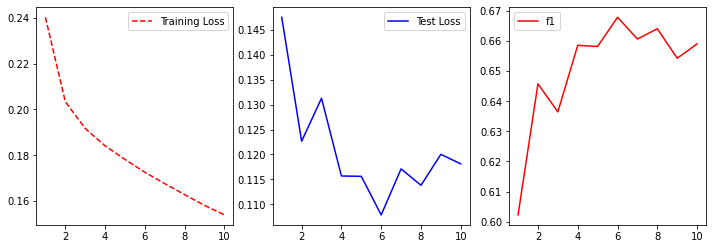

In [67]:
plot_graph_train(history.history)

In [68]:
# load best model
best_model = load_model('./best_classification_model/best.hdf5', compile=False)
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

In [69]:
threshold = 0
with strategy.scope():
    from sklearn import metrics
    y_pre=best_model.predict(padded_validate_sequences, verbose=1, batch_size=1024)
    max_f1 = 0
    for thresh in np.arange(0.1,0.9,0.01):
        f1 = metrics.f1_score(validate_label,(y_pre>thresh).astype(int))
        if f1 > max_f1:
            threshold=thresh
        print("threshold {0:2.2f} f1 score:{1:2.3f}".format(thresh,f1))

256/256 [==============================] - 149s 580ms/step
threshold 0.10 f1 score:0.559
threshold 0.11 f1 score:0.568
threshold 0.12 f1 score:0.576
threshold 0.13 f1 score:0.584
threshold 0.14 f1 score:0.590
threshold 0.15 f1 score:0.596
threshold 0.16 f1 score:0.601
threshold 0.17 f1 score:0.606
threshold 0.18 f1 score:0.611
threshold 0.19 f1 score:0.615
threshold 0.20 f1 score:0.620
threshold 0.21 f1 score:0.624
threshold 0.22 f1 score:0.628
threshold 0.23 f1 score:0.632
threshold 0.24 f1 score:0.635
threshold 0.25 f1 score:0.638
threshold 0.26 f1 score:0.641
threshold 0.27 f1 score:0.643
threshold 0.28 f1 score:0.647
threshold 0.29 f1 score:0.649
threshold 0.30 f1 score:0.652
threshold 0.31 f1 score:0.654
threshold 0.32 f1 score:0.657
threshold 0.33 f1 score:0.659
threshold 0.34 f1 score:0.661
threshold 0.35 f1 score:0.663
threshold 0.36 f1 score:0.665
threshold 0.37 f1 score:0.667
threshold 0.38 f1 score:0.668
threshold 0.39 f1 score:0.670
threshold 0.40 f1 score:0.671
threshold 0

In [70]:
y_test_pre=model.predict(padded_test_sequences, verbose=1, batch_size=1024)
y_test_pre=(y_test_pre>threshold).astype(int)

## Creating the submission File
submit=pd.DataFrame()
submit["qid"]=test_set.qid
submit["prediction"]=y_test_pre
submit.to_csv("submission.csv",index=False)

367/367 [==============================] - 7s 16ms/step
